# Imports

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy
import os
import glob
import pandas as pd
import math
import sys
plt.rcdefaults() #Setting default color of output plots
# For interactive plots

plt.rcParams.update({'figure.max_open_warning': 0})

# TODO:
    1) Check flag in HED file --> keep only 0 & 1
    2) Check "flag" in LED file --> add n-1 multiple of multihit
    3) Correct concatination of multiple files 

# Paths

In [10]:
path_HED = "/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF/"
path_LED = "/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/"
#path_HED = "/Users/andreas/phys/master/GRB/MATLAB/output/file_mat_TGF"
#path_LED = "/Users/andreas/phys/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF"

# Dict creation

In [3]:
#make a dictionary out of the manual trigger_ID list
triggers_data = pd.read_csv("trigger_ID.csv") #Manually created csv file that contains the GRB IDs, LED and HED filenames
GRB = triggers_data["GRB"].values
LED = triggers_data["LED"].values
HED = triggers_data["HED"].values
#Should be an easier way to sort the DF into an dict. Maybe transposing the DF
def create_triggers_dict():
    """
    trig_dict stores the GRB ID and LED/HED filenames.
    Key in dictionary is GRB id. Filenames are stored as tuple <LED,HED>
    return: trig_dict
    """
    trig_dict ={}
    
    try:
        if len(LED) & len(HED) != len(GRB):
            raise IndexError("Arrays not the same length. Check GRB,LED and HED")
        else:
            for i in np.arange(0,len(GRB)):
                GRB_name = GRB[i]
                LED_id = LED[i]
                HED_id = HED[i]
                trig_dict[GRB_name] = LED_id,HED_id
            return trig_dict
    except:
        raise

In [175]:
trig_dict_HED = {"GRB180720":["2018_07_20_14_21_48","2018_07_20_14_21_51","2018_07_20_14_21_56","2018_07_20_14_21_57","2018_07_20_14_22_09"],
                "GRB181222":["2018_12_22_20_11_36"],
                "GRB190206":["2019_02_06_03_49_28"],
                "GRB190305":["2019_03_05_13_05_19"],
                "GRB190501":["2019_05_01_05_23_22"],
                "GRB190606":["2019_06_06_01_55_07"],
                "GRB190829":["2019_08_29_19_56_40"],
                "GRB200412":[],# long lis
                "GRB200521":["2020_05_21_12_16_39"],
                "GRB200716":["2020_07_16_22_57_40"],
                "GRB200925":["2020_09_25_21_50_31"],
                "GRB201227":["2020_12_27_15_14_06"]}

In [161]:
trig_dict_LED = {"GRB181227":["2018_12_27_06_17_04.210500_Fulltrigger","2018_12_27_06_17_09.775992_Fulltrigger","2018_12_27_06_17_10.800851_Fulltrigger"],
                "GRB190117":["2019.01.17_08.50.42.939689_Fulltrigger"],
                 "GRB190420":["2019.04.20_23.32.24.931211_Fulltrigger"],
                 "GRB190501":["2019.05.01_05.23.21.736797_Fulltrigger"],
                 "
                }

# Functions for handling matlab files

In [132]:
def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4. 0->1 1->2// 0: tus=105, 1: tus=110,110 (two counts)
    '''
    mat = scipy.io.loadmat(path_LED + "%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)
    
    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel
    
    
    #Logic that checks for array lengths
    try:
        length = len(tus_keep_multihit)
        if any(len(lst) != length for lst in [erg_keep_multihit, multihit_indx]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        t_temp = []
        erg_temp = []
        
        for index, i in enumerate(multihit_indx):
            for j in np.arange(0,i+1): #adding i+1 times the tus_count
                t_temp.append(tus_keep_multihit[index])
                erg_temp.append(erg_keep_multihit[index])
         
        tus_keep_multihit_ntimes =  np.array(t_temp) #array of tus. Multihit index decides how many times the tus is appended
        erg_keep_multihit_ntimes = np.array(erg_temp) #array of erg. Multihit index decides how many times the erg is appended
        
        return tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx 
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus_keep_multihit, erg_keep_multihit, multihit_indx]:
            print(len(lst))

In [109]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative times in microseconds.
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal (0), fast(1), valley (3), or overflow event (2 or 4 not )
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    
    - Kepping only normal (0) and fast (1) events
    '''
    matlabfile_TGF = path_HED + '%s.mat' % matlabfilename
    
    mat = scipy.io.loadmat(matlabfile_TGF)
    
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    DetCol = mat['DetCol'] # Investigate this matrix
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    
    date = mat['date'].flatten() #raw datetime
    
    
    try:
        length = len(tus)
        if any(len(lst) != length for lst in [erg, typ, adr, dau, det]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        mask = np.where((typ != 0) & (typ != 1)) #finding indecies of vallays and overflow events
        
        # removing those indecies
        tus = np.delete(tus,mask)
        erg = np.delete(erg,mask)
        adr = np.delete(adr,mask)
        dau = np.delete(dau,mask)
        det = np.delete(det,mask)
        typ = np.delete(typ,mask)
        
        
        return tus, erg, typ, adr, dau, det, DetCol, date
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus,erg, typ, adr, dau, det]:
            print(len(lst))

# Plotting functions

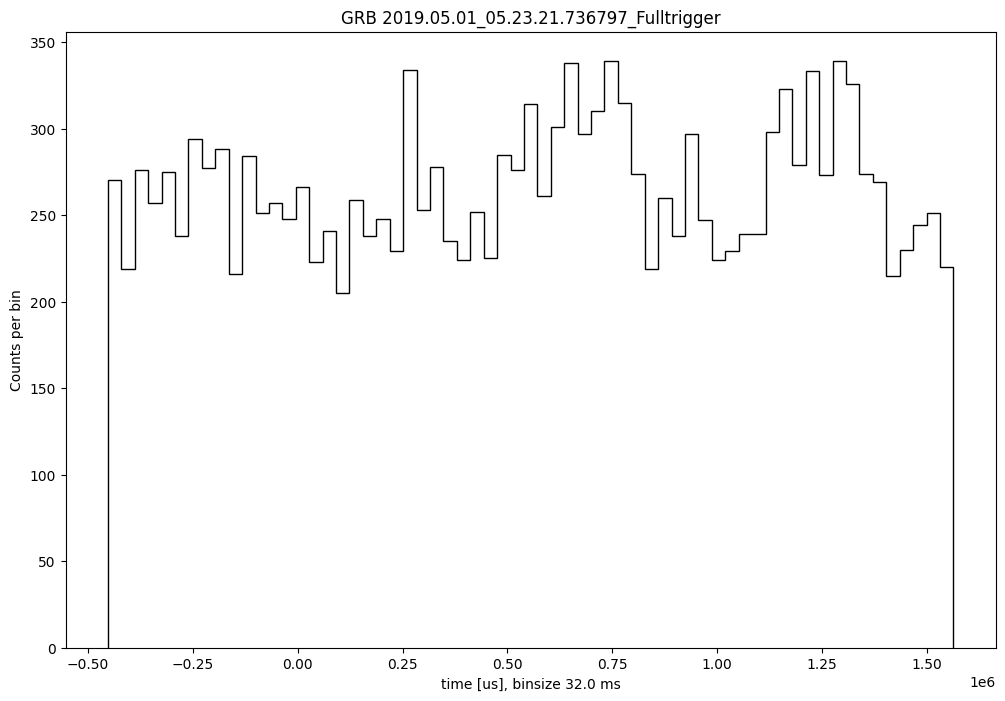

In [173]:
plot_LED("2019.05.01_05.23.21.736797_Fulltrigger",binsize=32)

# Original plotting functions

In [156]:
def plot_LED(LED_filename, binsize=10,start_range =0, end_range=0):
    tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED = read_matlab_file_with_CZT_data(
    LED_filename)

    binsize = binsize*1e3 #converting to microseconds
    start_range = start_range*1e3 #converting to microseconds
    end_range = end_range*1e3
    
    fig0, ax1 = plt.subplots(
        1, 1, figsize=(12, 8), sharex=True, sharey=False)
    
    ax1.hist(tus_keep_multihit_LED, bins=np.arange(
        min(tus_keep_multihit_LED), max(tus_keep_multihit_LED) + binsize, binsize),edgecolor= "black", histtype="step")
    ax1.set_xlabel("time [us], binsize {} ms".format((binsize / 1e3)))
    ax1.set_ylabel("Counts per bin")
    ax1.set_title("GRB " + LED_filename)
    
    if start_range and end_range != 0:
        mean = get_mean(LED_filename,binsize,tus_LED, start_range, end_range)
        ax1.axhline(y=mean, color="red", label="Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_LED)/1e6,3),start_range/1e6, end_range/1e6, np.round(max(tus_LED)/1e6,3)),linestyle='--')
                                                                                                                              
                                                                                                                          
        ax1.legend()
        plt.show()
    else:
        plt.show()
        
    #plt.savefig(output_dir + "/{}_LED".format(grb_id))
    
def plot_HED(HED_filename, output_dir,grb_id):
    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)

    fig0, (ax0, ax1) = plt.subplots(
        2, 1, figsize=(8, 8), sharex=True, sharey=False)
    ax0.set_title("HED")

    ax0.scatter(tus_HED, erg_HED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy channel")

    binsize = 10000  # us --> 10 ms bin
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")
    
    output_dir_hed = output_dir + "/{}_HED".format(grb_id)
    print(output_dir_hed)
    plt.savefig(output_dir + "/{}_HED".format(grb_id)) #path where plot is saved



In [178]:
def plot_HED(HED_filename,binsize=10, start_GRB=0, end_GRB=0):
    
    """Plotting data from HED.
        If start and end value for the GRB is not given, the data is plotted normally,
        - BINSIZE IS INITIALIZED AS MILLISECONDS
        - start_GRB & end_GRB IS INITIALIZED AS MILLISECONDS 0.5 s = 500 ms
        - tus_HED is given in microseconds
    """
    
    binsize = binsize*1e3 #converting to microseconds\n",
    
    start_GRB = start_GRB*1e3 #converting to microseconds\n",
    end_GRB = end_GRB*1e3,

    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)
    
    fig0, ax1 = plt.subplots(
        1, 1, figsize=(12, 8), sharex=True, sharey=False)
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")
    
    ax1.set_xlabel("time [us] binsize {} ms".format((binsize / 1e3)))
    ax1.set_ylabel("Counts per bin"),
    ax1.set_title("GRB" + HED_filename) #use dict to get id


    if start_GRB and end_GRB != 0:
        mean = get_mean(HED_filename,binsize,tus_HED, start_GRB, end_GRB)
        ax1.axhline(y=mean, color="red", label= "Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_HED)/1e6,3),start_GRB/1e6, end_GRB/1e6, np.round(max(tus_HED)/1e6,3)),linestyle='--'),
        ax1.legend()
        plt.show(),
    else:
        plt.show()

# main function

In [8]:
def main(grb_id,binsize=10000, start_GRB, end_GRB):  # filename GRB ID
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres
    # Automake by making filename a list of filenames. Then the all the outout plots will be created

    # TODO:
    # Add the extra parameters to make the get_mean work
#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")
    trig_dict = create_triggers_dict()
    try:
        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id
    except FileExistsError:
        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists


    if type(grb_id) != str:
        raise TypeError("Input is not string")
    elif grb_id not in trig_dict:
        raise LookupError("grb_id not in dictionary")
    else:
        try:
            LED_filename = trig_dict[grb_id][0]
            HED_filename = trig_dict[grb_id][1]
            if type(LED_filename) == float and math.isnan(LED_filename):
                print("LED file not found. Plotting only HED")
                plot_HED(HED_filename,output_dir,grb_id) #output path is not required
                
            elif type(HED_filename) == float and math.isnan(HED_filename):
                print("HED file not found. Plotting only LED")
                plot_LED(LED_filename,output_dir,grb_id)
            else:
                plot_LED(LED_filename,output_dir,grb_id)
                plot_HED(HED_filename,output_dir,grb_id)
        except:
            print("Something went wrong")
    
    

SyntaxError: non-default argument follows default argument (2792431290.py, line 1)

# Plotting cont'd

In [174]:
plot_HED("2019_05_01_05_23_22", binsize = 16)

TypeError: plot_HED() got an unexpected keyword argument 'binsize'

# Finding the background

- Background should be estimated for a "smart" region before the GRB --> a couple of samples in & a couple of samples before the GRB

In [126]:
tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data('2020_05_21_12_16_39')

In [5]:
# Rename start_GRB to start_range. Same for end_GRB

def get_mean(matlab_filename, binsize, tus, start_GRB, end_GRB):
    
    """Function for getting the mean from the background.
    matlab_filename: <str> filename
    binsize: <int> given in us // 5ms = 5000 us 
    start & end_GRB given in us.
    -Finding ranges to compute the mean in each bin. """
    
    tus = np.sort(tus)
    range_1 =  find_closest(tus,start_GRB)
    range_2 = find_closest(tus,end_GRB)
    
    range_1_counts = np.histogram(tus[:range_1], bins=np.arange(
        min(tus[:range_1]), max(tus[:range_1]) + binsize, binsize))[0]
    
    range_2_counts = np.histogram(tus[range_2:], bins=np.arange(
        min(tus[range_2:]), max(tus[range_2:]) + binsize, binsize))[0]
    
    background_data = np.append(range_1_counts,range_2_counts)
    mean = np.mean(background_data)
    return mean

In [146]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

# Graveyards

In [ ]:
# Not in use
def get_filenames(path):
    return sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)